# How to fit the Convergent Swap Intensity model to historical data through PyMC3

*Danilo Lessa Bernardineli (danilo@block.science)*

In [1]:
%load_ext autotime

time: 140 µs (started: 2021-08-04 16:06:12 -03:00)


In [2]:
# Load depencens
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import plotly.express as px

time: 3.14 s (started: 2021-08-04 16:06:12 -03:00)


In [3]:
# Load data
RUNTIME = '2021-06-14 00:11:39.492138'
DATA_PATH = f'../data/runs/{RUNTIME}-backtesting.csv.gz'

time: 208 µs (started: 2021-08-04 16:06:15 -03:00)


In [4]:
# Read data and assign the delta RAI reserve var
df = (pd.read_csv(DATA_PATH)
        .assign(delta_rai_reserve=lambda df: df.rai_reserve.diff())
        .dropna())

print(df.columns)

FEATURES = {'rai_reserve', 'market_price', 'redemption_price'}

Index(['rai_reserve', 'eth_reserve', 'rai_debt', 'eth_locked',
       'redemption_price', 'redemption_rate', 'proportional_error',
       'integral_error', 'kp', 'ki', 'leaky_factor', 'period', 'enabled',
       'seconds_passed', 'timedelta_in_hours', 'eth_price', 'market_price',
       'spot_price', 'simulation', 'subset', 'run', 'timestep',
       'delta_rai_reserve'],
      dtype='object')
time: 16.4 ms (started: 2021-08-04 16:06:15 -03:00)


### Model 1

The math spec of the model to be fitted is:

$$\frac{\Delta R_{RAI}}{R_{RAI}} = R_{RAI} \frac{(\sqrt{p_m - p_r} - 1)}{R_{RAI}} Unif[0, a]$$

Where $a$ is a parameter to be estimated.

Notice the division by $R_{RAI}$. This makes a bit easier on the MC search as the feature and labels becomes normalized.


In [5]:
# Prepare feature and label datasets
X = df.loc[:, FEATURES]
y = df.delta_rai_reserve / df.rai_reserve

with pm.Model() as model:
    
    # Upper bound parameter. This is the CSI parameter that's being used on the DT
    intensity_upper_bound = pm.Uniform('I_u', 0.0, 1)
    
    # Equivalent to the random() on the CSI model.
    sample_intensity = pm.Uniform('I_s', 0, intensity_upper_bound)
    
    sqrt_term = (X['market_price'] / X['redemption_price']) ** 2
    optimal_delta_rai = X['rai_reserve'] * (sqrt_term - 1)
    sample_delta_rai = sample_intensity * optimal_delta_rai / X['rai_reserve']
    
    # Estimate error distribution
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1)
    
    # Minimize likelihood
    likelihood = pm.Normal('actual_delta_rai', 
                           mu=sample_delta_rai, 
                           sigma=sigma, 
                           observed=y)
    
    # Find posteriors
    trace = pm.sample(5_000, 
                      return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I_s, I_u]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 20 seconds.


time: 27.7 s (started: 2021-08-04 16:06:15 -03:00)


In [6]:
print(f"I_u (avg): {trace.posterior.I_u.mean().values :.3f}")
print(f"I_u (std): {trace.posterior.I_u.std().values :.3f}")
print("-- IQR --")
print(f"I_u (10%): {trace.posterior.I_u.quantile(0.1).values :.3f}")
print(f"I_u (25%): {trace.posterior.I_u.quantile(0.25).values :.3f}")
print(f"I_u (50%): {trace.posterior.I_u.quantile(0.5).values :.3f}")
print(f"I_u (75%): {trace.posterior.I_u.quantile(0.75).values :.3f}")
print(f"I_u (90%): {trace.posterior.I_u.quantile(0.9).values :.3f}")

I_u (avg): 0.357
I_u (std): 0.267
-- IQR --
I_u (10%): 0.060
I_u (25%): 0.138
I_u (50%): 0.286
I_u (75%): 0.542
I_u (90%): 0.783
time: 5.25 ms (started: 2021-08-04 16:06:43 -03:00)


---

Now that we have sampled the posterior distributions, we can visualize them. The variable of interest is $I_u$, which informs the CSI parameter. Notice that there's a wide distribution between 0 and 1, with mean estimate on 0.36, which indicates that this is the best guess for the real parameter.

The variance on the posterior indicates that a best approach would be to do paramter sweeps and weight them according to the associated probability mass distribution if the goal is to inform a future trajectory.

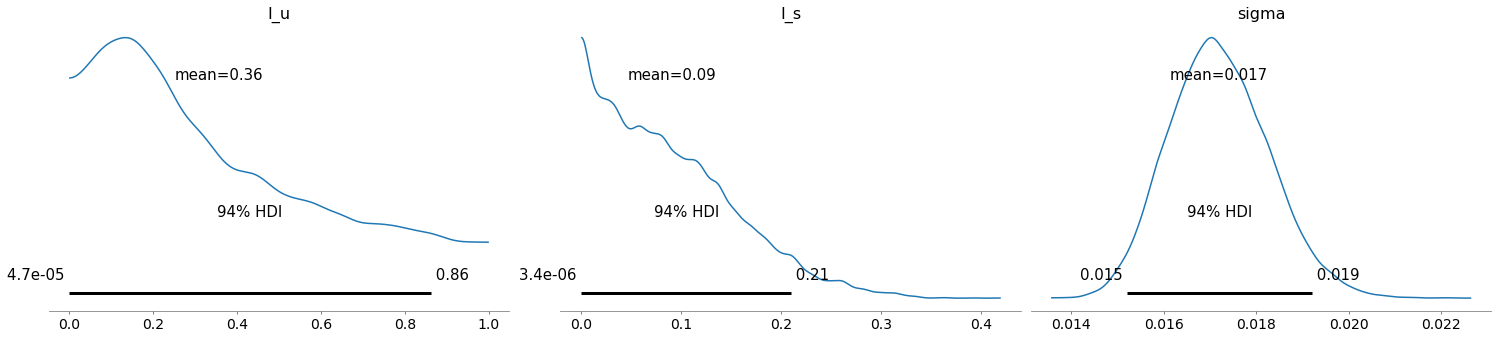

time: 290 ms (started: 2021-08-04 16:06:43 -03:00)


In [7]:
# Plot posterior distributions
pm.plot_posterior(trace)
plt.show()